In [1]:
import sys
import os
from importlib import reload
here = os.getcwd()
sys.path.append(os.path.join(here,"../"))

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

In [57]:
import explainer.rule_pattern_miner as rlm
import explainer.explainer_utils as eutils
from explainer.itemsets_miner import transform_intgrad_to_itemsets,gen_freq_feature_set

# from explainer.FPGrowth_tree import *
# from explainer.rule_pattern_miner import *
# from explainer.explainer_utils import *
# import explainer.RuleGrowth_tree as rgtree
from sklearn.metrics import f1_score,confusion_matrix,precision_score,recall_score,accuracy_score,roc_auc_score
from itertools import permutations

In [5]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

In [10]:
# Define a simple CNN model
class Net(nn.Module):
    def __init__(self,image_w=28,image_h=28,num_class=10,input_channel=1,output_channel=4,kernel=5,hidden_state=128):
        super(Net, self).__init__()
        self.output_channel = output_channel
        self.w = int((image_w - kernel + 1)/2)
        self.h = int((image_h - kernel + 1)/2)
        
        self.conv1 = nn.Conv2d(input_channel, output_channel, kernel)  # 1 input channel, 32 output channels, 5x5 kernel
       
        self.fc1 = nn.Linear(output_channel * self.w * self.h, hidden_state)  # Fully connected layer with 10 output classes
        self.fc2 = nn.Linear(hidden_state, num_class)
        
    def latent1(self,x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = x.view(-1, self.output_channel * self.w * self.h)
        return x
    
    def latent2(self,x):        
        x = F.relu(self.fc1(x))
        return x
        
    def forward(self, x):
        x = self.latent1(x)
        x = self.latent2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
    def latent_representation(self,x):
        x = self.latent2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [7]:
# Define data transformations and load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

dpath = "../../data/"
trainset = torchvision.datasets.MNIST(root=dpath, train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=8)

# Define data transformations and load the MNIST test dataset
testset = torchvision.datasets.MNIST(root=dpath, train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=8)


In [11]:
# Initialize the model and optimizer
model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training loop
for epoch in range(50):  # Change the number of epochs as needed
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 400 == 399:
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 400:.3f}')
            running_loss = 0.0

print('Finished Training')

Epoch 1, Batch 400, Loss: 1.714
Epoch 1, Batch 800, Loss: 0.443
Epoch 2, Batch 400, Loss: 0.296
Epoch 2, Batch 800, Loss: 0.258
Epoch 3, Batch 400, Loss: 0.219
Epoch 3, Batch 800, Loss: 0.185
Epoch 4, Batch 400, Loss: 0.166
Epoch 4, Batch 800, Loss: 0.161
Epoch 5, Batch 400, Loss: 0.141
Epoch 5, Batch 800, Loss: 0.133
Epoch 6, Batch 400, Loss: 0.121
Epoch 6, Batch 800, Loss: 0.120
Epoch 7, Batch 400, Loss: 0.112
Epoch 7, Batch 800, Loss: 0.106
Epoch 8, Batch 400, Loss: 0.105
Epoch 8, Batch 800, Loss: 0.092
Epoch 9, Batch 400, Loss: 0.093
Epoch 9, Batch 800, Loss: 0.088
Epoch 10, Batch 400, Loss: 0.083
Epoch 10, Batch 800, Loss: 0.085
Epoch 11, Batch 400, Loss: 0.081
Epoch 11, Batch 800, Loss: 0.076
Epoch 12, Batch 400, Loss: 0.074
Epoch 12, Batch 800, Loss: 0.070
Epoch 13, Batch 400, Loss: 0.069
Epoch 13, Batch 800, Loss: 0.072
Epoch 14, Batch 400, Loss: 0.066
Epoch 14, Batch 800, Loss: 0.066
Epoch 15, Batch 400, Loss: 0.062
Epoch 15, Batch 800, Loss: 0.063
Epoch 16, Batch 400, Loss: 0

In [49]:
inputs.shape

torch.Size([16, 1, 28, 28])

In [12]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on the test set: {100 * correct / total:.2f}%')


Accuracy on the test set: 98.41%


In [14]:
correct = 0
total = 0
X_train, X_train_raw = [],[]
y_train, pred_y_train = [],[]
train_reps = []
with torch.no_grad():
    for data in trainloader:
        inputs, labels = data
        
        X_train_raw.append(inputs)
        X_train.append(model.latent1(inputs).detach())
        y_train.append(labels)        
        
        outputs = model(inputs).detach()
        train_reps.append(outputs) 
        predicted = torch.argmax(outputs,dim=1)
        pred_y_train.append(predicted)        
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
X_train = torch.vstack(X_train)
X_train_raw = torch.vstack(X_train_raw)
train_reps = torch.vstack(train_reps)

y_train = torch.concat(y_train).numpy()
pred_y_train = torch.concat(pred_y_train).numpy()

print(f'Accuracy on the training set: {100 * correct / total:.2f}%')

Accuracy on the training set: 99.67%


In [15]:
pred_y_train[:5],y_train[:5]

(array([0, 8, 3, 5, 2]), array([0, 8, 3, 5, 2]))

In [103]:
# X_train = trainset.data.float().unsqueeze(1)
# y_train = trainset.targets
# train_reps = net.latent_representation(X_train)

# pred_y_train = torch.argmax(net(X_train).detach(),dim=1).numpy()
# X_test = testset.data.float().unsqueeze(1)
# pred_y_test = torch.argmax(net(X_test).detach(),dim=1).numpy()

In [104]:
# y_train = y_train.numpy()
# y_test = testset.targets.numpy()

In [61]:
reload(eutils)

<module 'explainer.explainer_utils' from '/Users/chenyu/github/INSPIRE/code/notebooks/../explainer/explainer_utils.py'>

In [16]:
baselines = eutils.gen_intgrad_baselines(X_train,y_train,train_reps)
subset = eutils.gen_balanced_subset(X_train,y_train,size_per_class=1000)

In [17]:
len(baselines)

10

In [18]:
int_g, z_shift = eutils.calc_baselines_intg(test_examples=subset,model=model,baselines=baselines,C=10)

In [21]:
int_g.shape,z_shift.shape

(torch.Size([90000, 576]), torch.Size([90000, 10]))

In [34]:
y_int_g = []
C=10
n_c = int(len(int_g)/C)
for c in range(C):
    tmp = torch.abs(int_g[c*n_c:(c+1)*n_c,:]/z_shift[c*n_c:(c+1)*n_c,c].reshape(-1,1))
    tmp[torch.isnan(tmp)] = 0.
    
    y_int_g.append(tmp)


In [19]:
# from sklearn.metrics import roc_curve, roc_auc_score
# import matplotlib.pyplot as plt
# import scipy as sp

# pred_y = sp.special.expit(pred_y_train)
# auc = roc_auc_score(y_train, pred_y,multi_class='ovr')
# fpr, tpr, thresholds = roc_curve(y_train, pred_y)
# y_thd = thresholds[np.argmax(tpr - fpr)]
# print("y threshold",y_thd)

# # Plot the ROC curve
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend()
# plt.grid()
# plt.show()

In [111]:
# C=10
# baseline_reps = model.latent_representation(baselines).detach()
# baseline_output = model(baselines).detach()

# subset_reps,subset_output = [],[]
# for k in range(C):
#     subset_reps.append(model.latent_representation(subset[k]))
#     subset_output.append(model(subset[k]).detach())

In [112]:
# cids = np.arange(C)
# yshift = []
# for k in cids:
#     for kk in cids[cids!=k]:
#         yshift.append(subset_output[k]-baseline_output[kk])
# yshift = torch.vstack(yshift)

In [30]:
# weights = linear_prams[0].reshape(-1,args.hidden_channels)
# y_int_g = output_intg_score(int_g,weights,yshift)
# y_int_g[torch.isnan(y_int_g)] = 0.

In [41]:
y_int_g[c].mean()

tensor(0.0001)

In [47]:
c = 0
thds = np.linspace(0.00001,0.001,1000)
f_n = []
for thd in thds:
    mask = torch.abs(y_int_g[c]) >= thd 
    f_n.append((thd,(mask.sum(dim=0)>=len(y_int_g[c])*0.9).sum()))
    print(f_n[-1])
    if f_n[-1][1]==1:
        break
thd = f_n[-1][0]
thd

(1e-05, tensor(157))
(1.0990990990990992e-05, tensor(143))
(1.1981981981981982e-05, tensor(133))
(1.2972972972972973e-05, tensor(120))
(1.3963963963963964e-05, tensor(108))
(1.4954954954954956e-05, tensor(93))
(1.5945945945945947e-05, tensor(81))
(1.693693693693694e-05, tensor(73))
(1.792792792792793e-05, tensor(64))
(1.891891891891892e-05, tensor(56))
(1.9909909909909912e-05, tensor(52))
(2.09009009009009e-05, tensor(44))
(2.1891891891891892e-05, tensor(36))
(2.2882882882882883e-05, tensor(30))
(2.387387387387387e-05, tensor(26))
(2.4864864864864862e-05, tensor(24))
(2.5855855855855854e-05, tensor(20))
(2.6846846846846845e-05, tensor(18))
(2.7837837837837836e-05, tensor(17))
(2.8828828828828828e-05, tensor(15))
(2.981981981981982e-05, tensor(14))
(3.081081081081081e-05, tensor(14))
(3.18018018018018e-05, tensor(14))
(3.279279279279279e-05, tensor(14))
(3.3783783783783784e-05, tensor(12))
(3.4774774774774776e-05, tensor(10))
(3.576576576576577e-05, tensor(9))
(3.675675675675676e-05, te

5.558558558558558e-05

Text(0, 0.5, 'Log number of features with max frequecy')

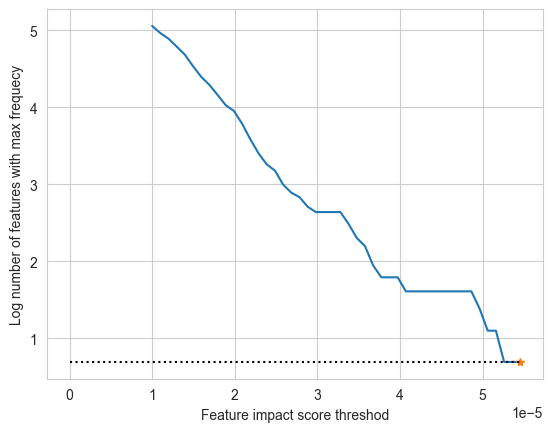

In [48]:
sns.set_style("whitegrid")
plt.plot([th[0] for th in f_n[:-1]],[np.log(th[1].numpy()) for th in f_n[:-1]])
plt.plot(f_n[-2][0],np.log(f_n[-2][1].numpy()),"*")
plt.plot([0,f_n[-2][0]],[np.log(f_n[-2][1].numpy()),np.log(f_n[-2][1].numpy())],":k")
#plt.xlim(0.01,0.04)
#plt.ylim(0.,750)
plt.xlabel("Feature impact score threshod")
plt.ylabel("Log number of features with max frequecy")

In [54]:
itemsets_y = transform_intgrad_to_itemsets(y_int_g[c],thd=thd,K=1)
fids = gen_freq_feature_set(itemsets_y[0],min_support=1500,max_len=100)
fids = np.array(fids).astype(int)-1
print('feature set',fids,len(fids))

[235.0] 8568.0
[235.0, 75.0] 7753.0
[235.0, 75.0, 512.0] 6942.0
[235.0, 75.0, 512.0, 88.0] 6397.0
[235.0, 75.0, 512.0, 88.0, 513.0] 5915.0
[235.0, 75.0, 512.0, 88.0, 513.0, 501.0] 5317.0
[235.0, 75.0, 512.0, 88.0, 513.0, 501.0, 44.0] 4504.0
[235.0, 75.0, 512.0, 88.0, 513.0, 501.0, 44.0, 87.0] 4154.0
[235.0, 75.0, 512.0, 88.0, 513.0, 501.0, 44.0, 87.0, 224.0] 3858.0
[235.0, 75.0, 512.0, 88.0, 513.0, 501.0, 44.0, 87.0, 224.0, 489.0] 3317.0
[235.0, 75.0, 512.0, 88.0, 513.0, 501.0, 44.0, 87.0, 224.0, 489.0, 234.0] 2927.0
[235.0, 75.0, 512.0, 88.0, 513.0, 501.0, 44.0, 87.0, 224.0, 489.0, 234.0, 100.0] 2641.0
[235.0, 75.0, 512.0, 88.0, 513.0, 501.0, 44.0, 87.0, 224.0, 489.0, 234.0, 100.0, 77.0] 2327.0
[235.0, 75.0, 512.0, 88.0, 513.0, 501.0, 44.0, 87.0, 224.0, 489.0, 234.0, 100.0, 77.0, 64.0] 2134.0
[235.0, 75.0, 512.0, 88.0, 513.0, 501.0, 44.0, 87.0, 224.0, 489.0, 234.0, 100.0, 77.0, 64.0, 63.0] 2015.0
[235.0, 75.0, 512.0, 88.0, 513.0, 501.0, 44.0, 87.0, 224.0, 489.0, 234.0, 100.0, 77.0, 64

In [69]:
reload(rlm)

<module 'explainer.rule_pattern_miner' from '/Users/chenyu/github/INSPIRE/code/notebooks/../explainer/rule_pattern_miner.py'>

In [71]:
# rule_list = []
# k = 3
# for pfids in permutations(fids[:k]):
#     nfids = list(pfids) + list(fids[k:])

y_rule_candidates = rlm.gen_rule_list_for_one_target_greedy(X_train.numpy(),fids,pred_y_train==c,y=y_train,c=0,sort_by="cond_prob_y",
                                                            min_support=1000,num_grids=100,max_depth=3,top_K=10,
                                                            local_x=None,feature_types=None,
                                                            verbose=False)

#     for i, rules in enumerate(y_rule_candidates):   
#         rules["rules"] = rlm.replace_feature_names(rules["rules"],time_index=False)
#         y_rule_candidates[i] = rules
#     rule_list = rule_list + y_rule_candidates
# rule_list.sort(key=lambda x: x["cond_prob_y"], reverse=True)
y_rule_candidates

build_rule_tree
init rule tree
search rule for feature 234
check potential rule 234 3.3546591254150644 0.0 0.11359721482402146 16693.0
add rule [] 234 (3.3546591254150644, 0.0, 0.11359721482402146, 16693.0)
search rule for feature 74
check potential rule 74 2.494789197627819 0.0 0.1086101917305378 1900
add rule [234] 74 (2.494789197627819, 0.0, 0.1086101917305378, 1900)
search rule for feature 511
check potential rule 511 1.0934600531621446 3.135047084153301 6.810619527643378 1016
add rule [234, 74] 511 (1.0934600531621446, 3.135047084153301, 6.810619527643378, 1016)
check potential rule 511 1.0934600531621446 3.135047084153301 6.810619527643378 1016
add rule [234, 74] 511 (1.0934600531621446, 3.135047084153301, 6.810619527643378, 1016)
check potential rule 511 1.0934600531621446 3.135047084153301 6.810619527643378 1016
add rule [234, 74] 511 (1.0934600531621446, 3.135047084153301, 6.810619527643378, 1016)
check potential rule 511 1.0902102700175478 3.135047084153301 7.026829671378088 

check potential rule 511 1.1655344329976929 3.135047084153301 4.756623162163629 1003
add rule [234, 74] 511 (1.1655344329976929, 3.135047084153301, 4.756623162163629, 1003)
check potential rule 511 1.1655344329976929 3.135047084153301 4.756623162163629 1003
add rule [234, 74] 511 (1.1655344329976929, 3.135047084153301, 4.756623162163629, 1003)
check potential rule 511 1.1655344329976929 3.135047084153301 4.756623162163629 1003
add rule [234, 74] 511 (1.1655344329976929, 3.135047084153301, 4.756623162163629, 1003)
check potential rule 511 1.1655344329976929 3.135047084153301 4.756623162163629 1003
add rule [234, 74] 511 (1.1655344329976929, 3.135047084153301, 4.756623162163629, 1003)
check potential rule 511 1.1655344329976929 3.135047084153301 4.756623162163629 1003
add rule [234, 74] 511 (1.1655344329976929, 3.135047084153301, 4.756623162163629, 1003)
check potential rule 511 1.1655344329976929 3.135047084153301 4.756623162163629 1003
add rule [234, 74] 511 (1.1655344329976929, 3.1350

[{'rules': [(234, '<=', 0.11359721482402146),
   (74, '<=', 3.1496955601855965),
   (511, '>=', 3.135047084153301),
   (511, '<=', 3.351257227888011)],
  'cond_prob_target': 0.9341983317886933,
  'support': 1079,
  'cond_prob_y': 0.933271547729379,
  'ratio_y': 0.1700151950025325},
 {'rules': [(234, '<=', 0.11359721482402146),
   (74, '<=', 3.1496955601855965),
   (511, '>=', 3.135047084153301),
   (511, '<=', 3.5674673716227217)],
  'cond_prob_target': 0.9258137774413323,
  'support': 1321,
  'cond_prob_y': 0.9250567751703255,
  'ratio_y': 0.20631436771906128},
 {'rules': [(234, '<=', 0.11359721482402146),
   (74, '<=', 3.6927465188382853),
   (511, '>=', 3.135047084153301),
   (511, '<=', 3.351257227888011)],
  'cond_prob_target': 0.9211438474870017,
  'support': 1154,
  'cond_prob_y': 0.9202772963604853,
  'ratio_y': 0.179301029883505},
 {'rules': [(234, '<=', 0.11359721482402146),
   (74, '<=', 3.6927465188382853),
   (511, '>=', 3.135047084153301),
   (511, '<=', 3.567467371622721

In [72]:
y_rule_candidates

[{'rules': [(234, '<=', 0.11359721482402146),
   (74, '<=', 3.1496955601855965),
   (511, '>=', 3.135047084153301),
   (511, '<=', 3.351257227888011)],
  'cond_prob_target': 0.9341983317886933,
  'support': 1079,
  'cond_prob_y': 0.933271547729379,
  'ratio_y': 0.1700151950025325},
 {'rules': [(234, '<=', 0.11359721482402146),
   (74, '<=', 3.1496955601855965),
   (511, '>=', 3.135047084153301),
   (511, '<=', 3.5674673716227217)],
  'cond_prob_target': 0.9258137774413323,
  'support': 1321,
  'cond_prob_y': 0.9250567751703255,
  'ratio_y': 0.20631436771906128},
 {'rules': [(234, '<=', 0.11359721482402146),
   (74, '<=', 3.6927465188382853),
   (511, '>=', 3.135047084153301),
   (511, '<=', 3.351257227888011)],
  'cond_prob_target': 0.9211438474870017,
  'support': 1154,
  'cond_prob_y': 0.9202772963604853,
  'ratio_y': 0.179301029883505},
 {'rules': [(234, '<=', 0.11359721482402146),
   (74, '<=', 3.6927465188382853),
   (511, '>=', 3.135047084153301),
   (511, '<=', 3.567467371622721

In [87]:
r1 = X_train_raw[(X_train[:,511] <= 3.351257227888011)&(X_train[:,511] >= 3.135047084153301)&(X_train[:,74]<=3.1496955601855965)&(X_train[:,234]<=0.11359721482402146)]

In [88]:
r1[0].shape

torch.Size([1, 28, 28])

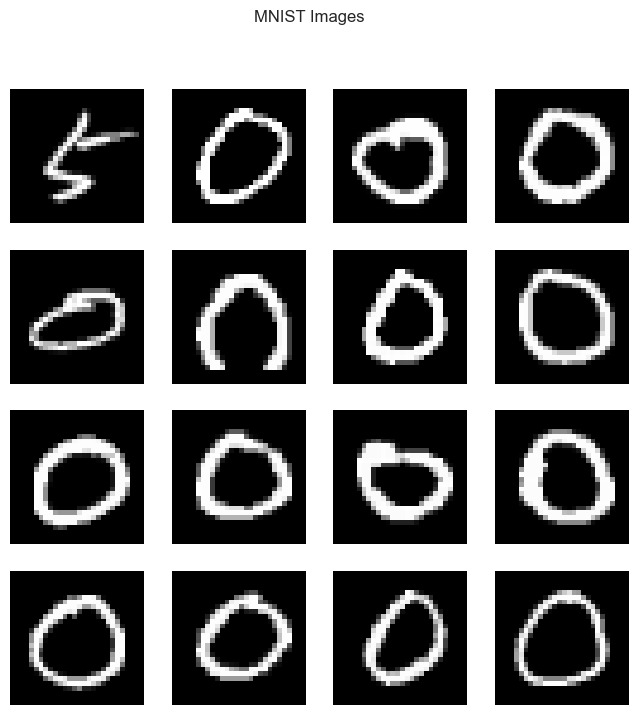

In [89]:

import matplotlib.pyplot as plt

# Create a figure with 16 subplots
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
fig.suptitle("MNIST Images")

# Display 16 MNIST images
for i in range(4):
    for j in range(4):
        index = i * 4 + j
        image = r1[index]
        axes[i, j].imshow(image.squeeze(), cmap='gray')
        #axes[i, j].set_title(f"Label: {label}")
        axes[i, j].axis('off')

plt.show()
